isolation Forestを使って異常値を検出してみます。
このページでは時系列データの中にいくつか異常値を混ぜ、それが検出できるかどうか検証します。

In [1]:
import japanize_matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.tree import plot_tree

### 人工データの作成
`[11, 49, 149, 240, 300, 310]`の日付にて異常値を混ぜておきます。
カテゴリ変数や整数の特徴も含まれるデータです。数値のみプロットしてみます。

<Axes: >

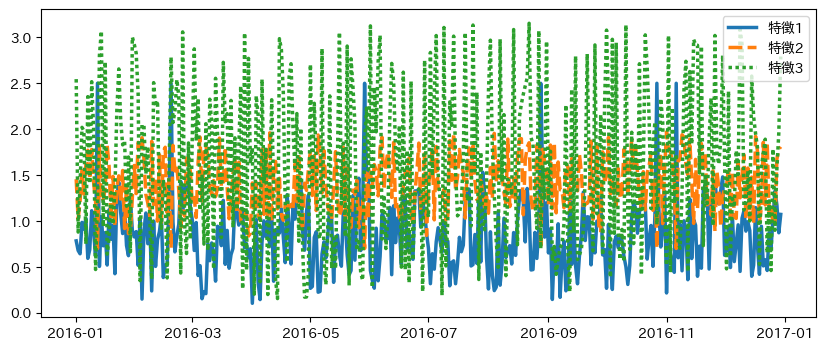

In [2]:
rs = np.random.RandomState(365)
dates = pd.date_range("1 1 2016", periods=365, freq="D")

data = {}
data["月"] = [d.strftime("%m") for d in dates]
data["曜日"] = [d.strftime("%A") for d in dates]
data["特徴1"] = [np.sin(d.day / 50) + np.random.rand() for d in dates]
data["特徴2"] = [np.cos(d.day / 50) + np.random.rand() for d in dates]
data["特徴3"] = [3 * np.random.rand() + np.log(d.dayofyear) * 0.03 for d in dates]
data["特徴4"] = [np.random.choice(["☀", "☂", "☁"]) for d in dates]
column_names = list(data.keys())


anomaly_index = [11, 49, 149, 240, 300, 310]
anomaly_dates = [dates[i] for i in anomaly_index]
for i in anomaly_index:
    data["特徴1"][i] = 2.5
    data["特徴2"][i] = 0.7


data = pd.DataFrame(data, index=dates)

plt.figure(figsize=(10, 4))
sns.lineplot(data=data, palette="tab10", linewidth=2.5)

In [3]:
data

,月,曜日,特徴1,特徴2,特徴3,特徴4
2016-01-01,01,Friday,0.782830,1.454781,2.545562,☀
2016-01-02,01,Saturday,0.678303,1.019389,0.878795,☀
2016-01-03,01,Sunday,0.642077,1.215777,1.400673,☂
2016-01-04,01,Monday,0.984236,1.567026,2.019912,☁
2016-01-05,01,Tuesday,0.910998,1.292531,1.980286,☁
...,...,...,...,...,...,...
2016-12-26,12,Monday,1.021910,0.963603,1.784995,☁
2016-12-27,12,Tuesday,1.325341,0.946619,0.898090,☂
2016-12-28,12,Wednesday,1.175691,1.673713,1.565966,☀
2016-12-29,12,Thursday,0.871166,1.780545,1.961752,☀


### カテゴリ変数の変換
「曜日」のような特徴をIsolation Forestで扱うためにダミー変数に変換します。

In [4]:
X = pd.get_dummies(data)
X

,特徴1,特徴2,特徴3,月_01,月_02,月_03,月_04,月_05,月_06,月_07,...,曜日_Friday,曜日_Monday,曜日_Saturday,曜日_Sunday,曜日_Thursday,曜日_Tuesday,曜日_Wednesday,特徴4_☀,特徴4_☁,特徴4_☂
2016-01-01,0.782830,1.454781,2.545562,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2016-01-02,0.678303,1.019389,0.878795,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2016-01-03,0.642077,1.215777,1.400673,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2016-01-04,0.984236,1.567026,2.019912,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2016-01-05,0.910998,1.292531,1.980286,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-26,1.021910,0.963603,1.784995,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2016-12-27,1.325341,0.946619,0.898090,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2016-12-28,1.175691,1.673713,1.565966,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2016-12-29,0.871166,1.780545,1.961752,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


### Isolation Forestの作成

In [5]:
model = IsolationForest(
    n_estimators=100,
    max_samples="auto",
    contamination=0.01,
    max_features=5,
    bootstrap=False,
    random_state=np.random.RandomState(365),
)

model.fit(X)

data["is_anomaly"] = model.predict(X) < 0
data["anomaly_score"] = model.decision_function(X)

### 検出した日付と正解の比較
異常値として検出したタイミングと正解を比較します。

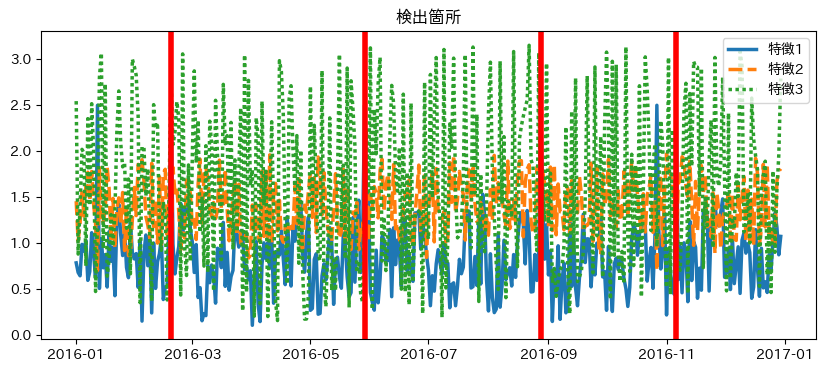

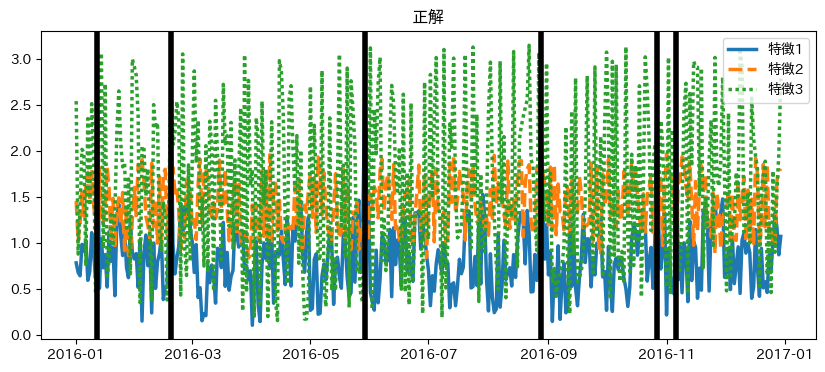

In [6]:
plt.figure(figsize=(10, 4))
plt.title("検出箇所")
sns.lineplot(data=data[column_names], palette="tab10", linewidth=2.5)
for d in data[data["is_anomaly"]].index:
    plt.axvline(x=d, color="red", linewidth=4)


plt.figure(figsize=(10, 4))
plt.title("正解")
sns.lineplot(data=data[column_names], palette="tab10", linewidth=2.5)
for d in anomaly_dates:
    plt.axvline(x=d, color="black", linewidth=4)

### 異常値のルール

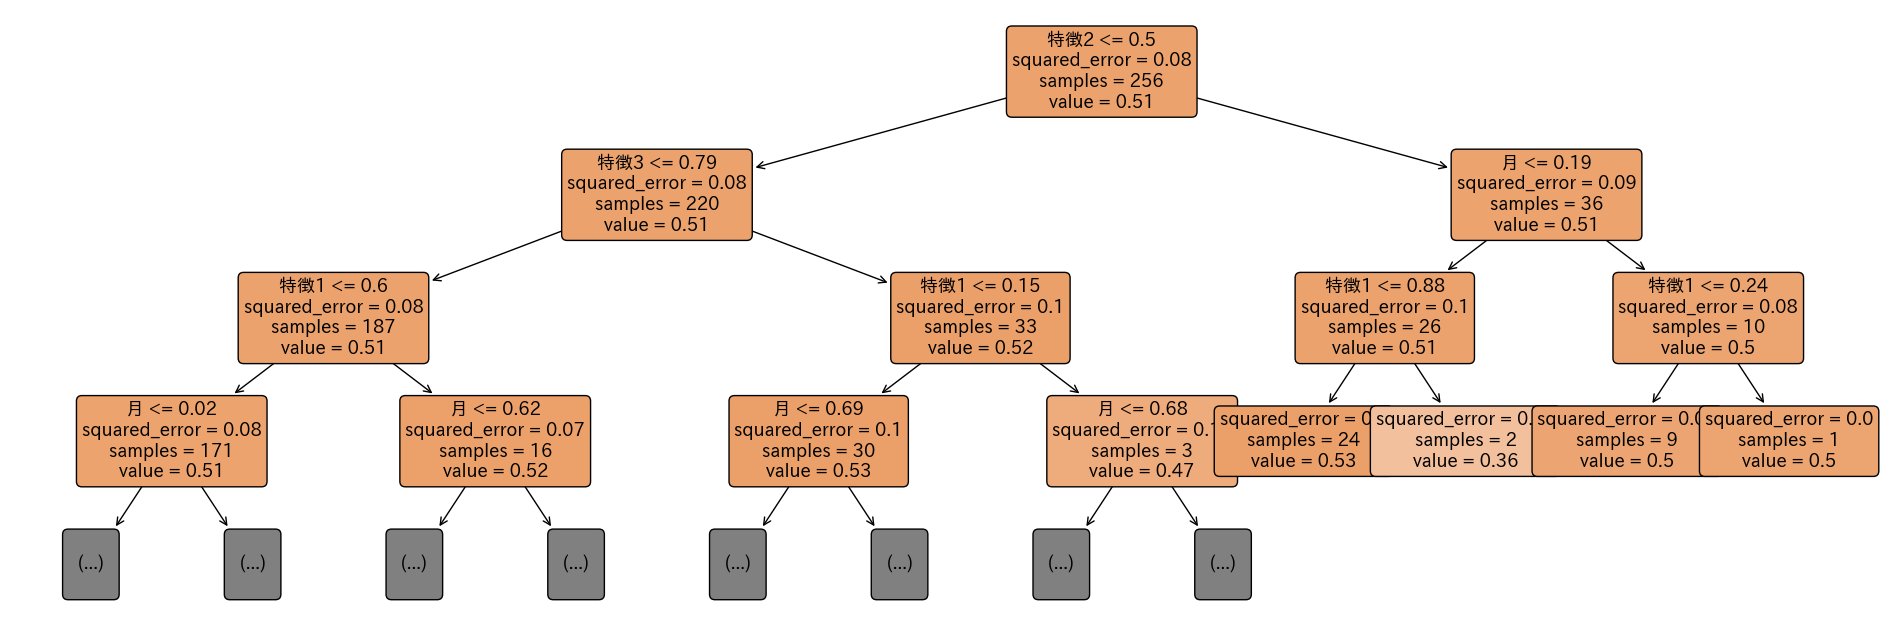

In [7]:
estimator = model.estimators_[0]
plt.figure(figsize=(24, 8))
plot_tree(
    estimator,
    feature_names=column_names,
    filled=True,
    fontsize=13,
    max_depth=3,
    precision=2,
    rounded=True,
)

plt.show()